In [212]:
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
import statistics
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)
size=200

In [213]:

@tf.function
def prep_plot(data):
  """
  Prepares data for plotting using TensorFlow functions and tensors.

  Args:
    data: A NumPy array representing the input data.

  Returns:
    A TensorFlow tensor representing the processed image.
  """

  # Extract events and reshape them
  events = data[:, 0]
  events_flat = tf.reshape(events, [-1])

  # Create sequence based on events
  sequence = tf.where(events_flat >= 0,
                     tf.ones_like(events_flat),
                     tf.zeros_like(events_flat))
  sequence = tf.repeat(sequence, tf.cast(tf.abs(events_flat), tf.int32))

  # Extract and repeat noise to match sequence length
  noise = tf.reshape(data[ :, 1], [-1])
  repeats = tf.math.ceil(tf.shape(sequence)[0] / tf.shape(noise)[0])
  repeated_noise = tf.tile(noise, [tf.cast(repeats, tf.int32)])
  noise = repeated_noise[:tf.shape(sequence)[0]]
  sequence = tf.convert_to_tensor(sequence)
  noise = tf.convert_to_tensor(noise)
  # Combine sequence and noise
  sim_raw = sequence + noise
  sim_chan = sequence

  # Stack channels and reshape into an image
  image = tf.stack([sim_chan, sim_raw], axis=1)[:size,:]

  # Print shape for debugging
  #tf.print(tf.shape(image))

  return image

In [214]:
# Parameters for the exponential distribution
O1 = tf.constant(10.0, dtype=tf.float32)  # Adjust this value as needed
C1 = tf.constant(3.0, dtype=tf.float32)
Anoise = tf.constant(0.1, dtype=tf.float32)
Fnoise = tf.constant(0.1, dtype=tf.float32)
nE = tf.constant(100, dtype=tf.float32) #number of events
n = 1  # Number of channels

num_samples = 50
dt = tf.constant(0.1, dtype=tf.float32)
T = tf.constant(1000, dtype=tf.int32)  # In sample points :-)
#Must be a multiple of 2!!!

@tf.function
def sim_channel(params):
    nE, To, Tc, Anoise, Fnoise = params
    nE = tf.cast(nE, dtype=tf.int32)
    t = tf.range(0, T, dtype=tf.float32) * dt
    # Generate exponentially distributed random numbers
    exp_dist_o = tfp.distributions.Exponential(rate=1.0 / To)
    exp_dist_c = tfp.distributions.Exponential(rate=1.0 / Tc)
    
    num_events = T // 2  # Approximate number of events
    
    # Generate exponentially distributed random numbers
    num_events = T // 2  # Approximate number of events
    open_durations = exp_dist_o.sample(nE)
    zeros = tf.zeros(num_events-nE)
    open_durations = tf.concat([open_durations,zeros],axis=0)
    #tf.print(tf.shape(open_durations))
    #open_events = tf.cast(open_durations/dt, dtype=tf.int32)
    closed_durations = exp_dist_c.sample(nE)* tf.constant(-1, dtype=tf.float32) 
    closed_durations= tf.concat([closed_durations,zeros], axis=0)
    #closed_events = tf.cast(closed_durations/dt, dtype=tf.int32)
    
    # Interweave the two vectors
    interwoven_durations = [val for pair in zip(open_durations, closed_durations) for val in pair]
    #events = [int(val/dt) for val in interwoven_durations]
    # If you want to convert it back to a TensorFlow tensor
    #sequence = tf.convert_to_tensor(interwoven_durations)
    
    sequence = tf.convert_to_tensor(interwoven_durations)

    """
    # Apply durations to state
    time_indices = tf.searchsorted(cumulative_durations, t)
    state = tf.gather(state, time_indices)
    """

    
    # Add noise
    pink_noise = generate_pink_noise(T)*Fnoise
    white_noise = tf.random.normal(shape=[T])*Anoise
    noise = pink_noise+white_noise
    #sequence = Anoise*pink_noise + 0.01 * white_noise
    sequence = tf.cast(sequence, tf.float32)
    noise = tf.cast(noise, tf.float32)
    record = tf.stack([sequence,noise],axis=1)
    
    return prep_plot(record)


# Make sure generate_pink_noise is also differentiable
@tf.function
def generate_pink_noise(T):
    white_noise = tf.random.normal([T])
    
    # Compute the number of unique FFT coefficients
    num_fft_pts = T // 2 + 1
    
    # Generate the frequency spectrum
    f = tf.range(1, num_fft_pts, dtype=tf.float32)
    spectrum = 1.0 / tf.sqrt(f)
    spectrum = tf.concat([tf.constant([1.0]), spectrum], axis=0)
    
    # Compute FFT of white noise
    white_noise_fft = tf.signal.rfft(white_noise)
    
    # Apply pink noise spectrum
    pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
    
    # Inverse FFT to get pink noise in time domain
    pink_noise = tf.signal.irfft(pink_noise_fft)
    
    # Normalize
    return pink_noise / tf.math.reduce_std(pink_noise)

# Generate training data
training_data = []
lens=[]
for sample in tqdm(range(num_samples)):   
    params = tf.stack([nE, O1, C1, Anoise, Fnoise])  # Use tf.stack instead of tf.constant
    segment = sim_channel(params)
    lens.append(sum(abs(segment)))
    training_data.append(segment)
print(f"Average duration was {sum(lens)/len(lens)}")


100%|██████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:13<00:00,  3.65it/s]

Average duration was [159.02   165.4478]


In [215]:
print(tf.shape(training_data))

tf.Tensor([ 50 200   2], shape=(3,), dtype=int32)


In [216]:
def funky_plot(plt_data):
    #plt_data is a list of datas, so if only one plot use [data]
    #Now just default titles. Posh up if needs changing
    titles = ["Generated", "Training"]
    if len(plt_data) == 1:
        fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    else:
        fig, axs = plt.subplots(len(plt_data), 1, figsize=(10, 6))
    for i, data in enumerate(plt_data):
        axs[i].plot(data)
        axs[i].set_title(titles[i])
        plt.show


In [217]:
#slim_sim = prep_plot(training_data)

#funky_plot([sim_raw,sim_raw])

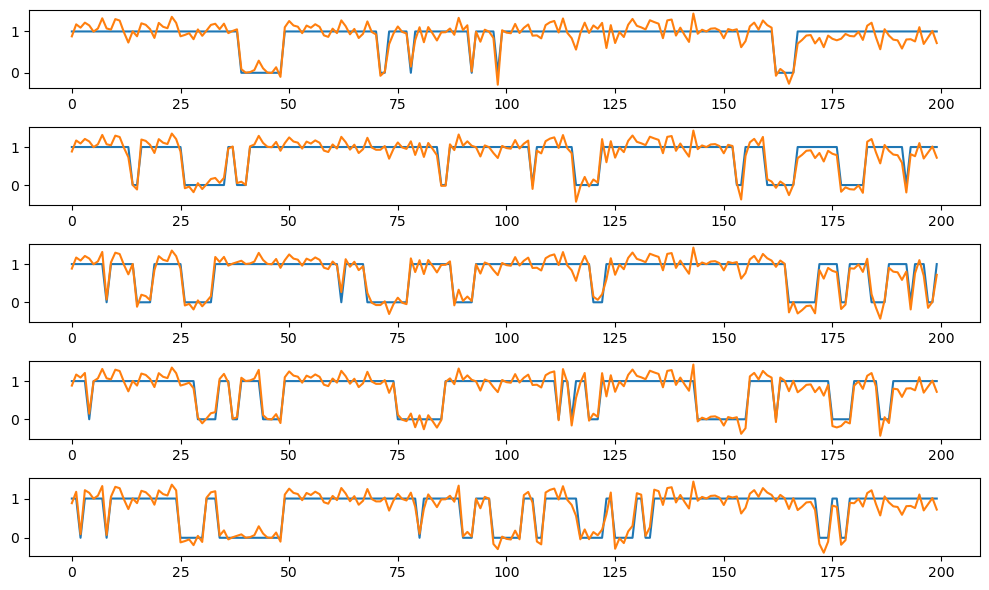

In [227]:
def plotter(data):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(5, 1, figsize=(10, 6))
    for i in range(5):
        axs[i].plot(data[i] )
        #axs[i].set_ylim([-200,200])
    plt.tight_layout()
    plt.show()

plotter(training_data)

In [223]:
# Define the generator model

def make_generator_model():
    noise_input = tf.keras.layers.Input(shape=(100,))
    x = tf.keras.layers.Dense(128, activation='relu')(noise_input)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer without activation
    raw_output = tf.keras.layers.Dense(5)(x)
    
    # Apply appropriate activations/scaling to each output
    nE = tf.keras.layers.Lambda(lambda x: tf.abs(x) + 10)(raw_output[:, 0:1])  # Positive, non-zero
    To= tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 0.1)(raw_output[:, 1:2])  # Positive, non-zero
    Tc = tf.keras.layers.Lambda(lambda x: tf.abs(x)+ 0.1)(raw_output[:, 2:3])  # Positive, non-zero
    #phase = tf.keras.layers.Lambda(lambda x: x * 2 * np.pi)(raw_output[:, 2:3])  # Any value, scaled to [0, 2π]
    Anoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 3:4])  # Positive
    Fnoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 4:5])  # Positive  
    output = tf.keras.layers.Concatenate()([nE, To, Tc, Anoise, Fnoise])
    #output = tf.keras.layers.Concatenate()([To, Tc])
    output = tf.keras.layers.Lambda(lambda x: x * 10)(output)  # Multiply by 10
    
    return tf.keras.Model(inputs=noise_input, outputs=output)


# Define the discriminator model batch, record len, channels = events then noise
num_points = T.numpy().item()
def make_discriminator_model():
    input_shape = (size,2) 
    inputs = tf.keras.Input(shape=input_shape)

    # Reshape input to add channel dimension
    x = tf.keras.layers.Reshape((size, 2))(inputs)
    
    # 1D Convolutional layers
    x = tf.keras.layers.Conv1D(8, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(16, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Dropout(0.3) (x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    """
    # Dense layers
    x = tf.keras.layers.Dense(256, activation='leaky_relu')(x)
    x = tf.keras.layers.Dense(128, activation='leaky_relu')(x)"""
    
    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output, from_logits=True))

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)


In [240]:
# Training step
@tf.function
def train_step(real_data):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_params = generator(noise, training=True)
        #tf.print("generated_params:", generated_params[0])
        
        generated_data = tf.map_fn(sim_channel, generated_params, fn_output_signature=tf.float32)
        #tf.print("generated_data shape:", tf.shape(generated_data))
        
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        #tf.print("real_output:", real_output[0])
        #tf.print("fake_output:", fake_output[0])
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    #tf.print("gen_loss:", gen_loss)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    steps_per_epoch = math.floor(num_samples / batch_size)
    tf.print("steps per epoch", steps_per_epoch)
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Initialize loss accumulators for each epoch
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        
        for step, batch in tqdm(enumerate(dataset), total=steps_per_epoch):
            #clear_output(wait=True)
            if step >= steps_per_epoch:
                break  # Move to the next epoch          
            try:
                gen_loss, disc_loss = train_step(batch)
                #tf.print("gen_loss",gen_loss)
                epoch_gen_loss += gen_loss
                #tf.print("epoch_gen_loss",gen_loss)
                epoch_disc_loss += disc_loss
            except Exception as e:
                print(f"Error during training: {e}")
                break

        #tf.print("epoch_gen_loss",epoch_gen_loss)
        # Calculate average losses for the epoch
        avg_gen_loss = epoch_gen_loss / steps_per_epoch
        avg_disc_loss = epoch_disc_loss / steps_per_epoch
        clear_output(wait=True)
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Generator Loss: {avg_gen_loss:.8f}, "
              f"Discriminator Loss: {avg_disc_loss:.8f}")
        
        # Generate and plot sine waves
        egs=5
        
        # Generate and plot sine waves
        EgNoise = tf.random.normal([egs, 100])
        #print("EgNoise", EgNoise[0])
        generated_params = generator(EgNoise, training=False)
        #print(steps_per_epoch)
        print("params", generated_params[0])
       
        gen_waves=[]
        for i in range(egs):
            gen_waves.append( sim_channel(generated_params[i]) )

        """
        # Create a figure with two subplots (panels)
        fig, axs = plt.subplots(egs, 1, figsize=(10, 6))
        for i in range(egs):
            axs[i].plot(gen_waves[i] )
            #axs[i].set_ylim([0,1])
        plt.tight_layout()
        plt.show()
        """
        #tf.print(tf.shape(gen_waves))
        random_index = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(gen_waves)[0], dtype=tf.int32)

        biPlotter([gen_waves[random_index],training_data[random_index]])

        plt.show()
              
        if (epoch + 1) % 10 == 0:
            print(f"Completed {epoch + 1} epochs")
            plt.savefig(f"chanFigs/fig{epoch}.png")


In [244]:
def biPlotter(data):
    # Create a figure with two subplots (panels)
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    axs[0].plot(data[0] )
    axs[0].set_title('Generated Wave')
    axs[1].plot(data[1] )
    axs[1].set_title('Training Data')
    #axs[i].set_ylim([-200,200])
    plt.tight_layout()
    plt.show()
    



In [245]:
batch_size = 10
training_dataset = tf.data.Dataset.from_tensor_slices(
    training_data).shuffle(num_samples).batch(batch_size, drop_remainder=True).repeat()


Epoch 76/20000 - Generator Loss: 0.67268342, Discriminator Loss: 1.37841916
params tf.Tensor([1.0354794e+02 7.0628071e+00 1.6906712e+00 2.4802649e-01 5.0403411e-03], shape=(5,), dtype=float32)


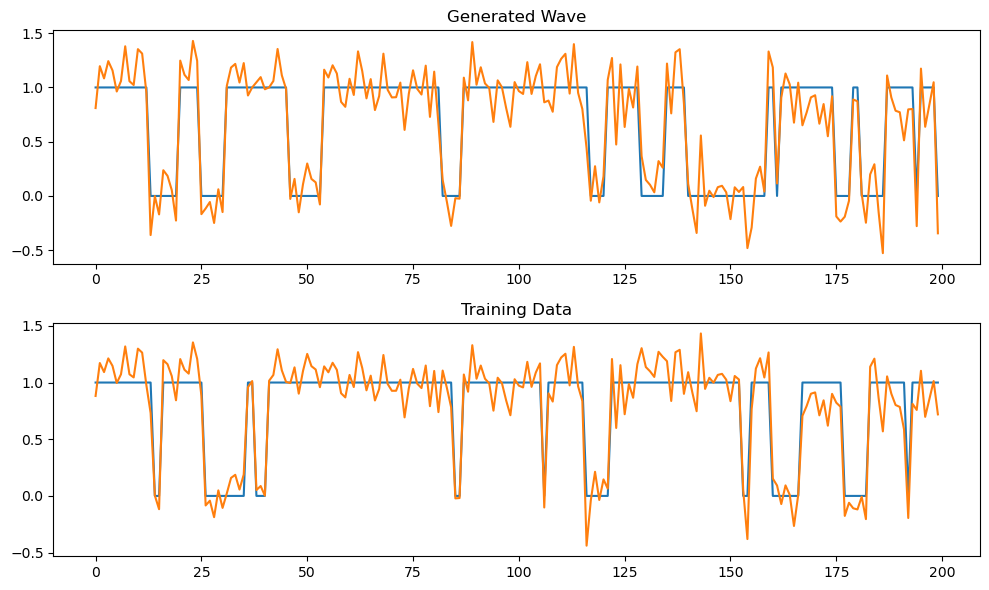

Epoch 77/20000


 40%|████████████████████████████████████▊                                                       | 2/5 [01:05<01:38, 32.67s/it]

In [ ]:
epochs=20000
train(training_dataset, epochs)

In [ ]:
num_samples=1000